[HRV]: P03 extraction done


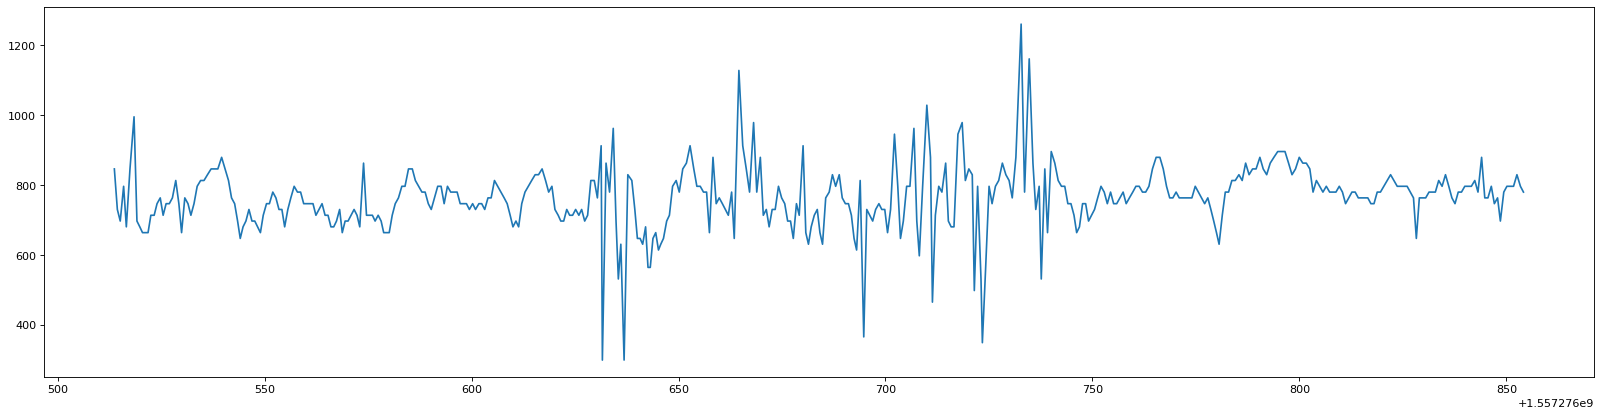

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import neurokit2

time_middle_file_path = 'middle-files/'
hrv_output_path = 'hrv-middle-data/'
eda_output_path = 'eda-middle-data/'
minimal_duration_minutes = 2
confidence_still_threshold = 0.5

p_index=2
participant_key = 'P' + str(p_index + 1).zfill(2)

df_time = pd.read_csv(f'{time_middle_file_path}{participant_key}_app_usage_events_with_confidences.csv')
df_hrv = pd.read_csv(f'dataset/{participant_key}/RRI.csv')
df_hrv.sort_values(by='timestamp')

df_hrv['RRI'] = df_hrv['interval']
df_hrv['RRI_Time_ms'] = df_hrv['timestamp']
df_hrv['RRI_Time'] = df_hrv['timestamp'] / 1000

filtered_use_time = df_time.loc[df_time.time_difference > minimal_duration_minutes * 60 * 1000]
loc_time = filtered_use_time.loc[df_time['confidenceStill'] >= confidence_still_threshold]

res = None
test_flag = False
plt.figure(figsize=(25, 6), dpi=80)
for index, row in loc_time.iterrows():
    foreground_time = row['foreground_time']
    background_time = row['background_time']

    df_analyse = df_hrv.loc[
        (df_hrv['timestamp'] >= foreground_time) & (df_hrv['timestamp'] <= background_time)]

    if len(df_analyse) == 0:
        continue

    # participants maybe not wearing the band in some cases, so check again here.
    if df_analyse.iloc[-1]['timestamp'] - df_analyse.iloc[0]['timestamp'] < minimal_duration_minutes * 60 * 1000:
        continue
    
    if test_flag is False:
        plt.plot(df_analyse['RRI_Time'], df_analyse['RRI'])

        test_flag = True

    res_row = neurokit2.hrv_time(df_analyse)
    res_row['foreground_time'] = foreground_time
    res_row['background_time'] = background_time

    if res is None:
        res = res_row
    else:
        res = pd.concat([res, res_row], ignore_index=True)

if res is not None:
    res.to_csv(hrv_output_path + participant_key + '_hrv_result.csv', index=False)
    print(f'[HRV]: {participant_key} extraction done')
else:
    print(f'[HRV]: {participant_key} has no result')


In [15]:
import glob
import os
from multiprocessing import Pool
from pathlib import Path

import pandas as pd

output_folder = 'middle-files/'
before_usage_confidence_time = 2 * 60 * 1000


# function to calculate average confidence levels
def calculate_average_confidence(start_time, end_time, activity_df):
    relevant_activities = activity_df[(activity_df['timestamp'] >= start_time) & (activity_df['timestamp'] <= end_time)]
    if not relevant_activities.empty:
        average_confidences = relevant_activities.mean(numeric_only=True).round(4)
        return average_confidences.to_dict()
    else:
        return {col: 0.0 for col in activity_df.columns if col != 'timestamp'}

def process_time(p_index):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    
    path = f'dataset/{participant_key}/AppUsageEvent.csv'
    
    if not os.path.isfile(path):
        print(path + ' do not exist.')
        return []
        
    df = pd.read_csv(path)

    filtered_data = df[
        (df['category'].isin(['SOCIAL']))
    ]
        
    return filtered_data['packageName'].unique()

apps = []
for i in range(80):
    for e in process_time(i):
        if e not in apps:
            apps.append(e)
print(apps)

dataset/P27/AppUsageEvent.csv do not exist.
dataset/P59/AppUsageEvent.csv do not exist.
dataset/P65/AppUsageEvent.csv do not exist.
['com.everytime.v2', 'com.facebook.katana', 'com.instagram.android', 'com.kakao.story', 'com.nhn.android.navercafe', 'com.dcinside.app', 'com.nhn.android.blog', 'com.cashslide', 'com.twitter.android', 'kr.co.vcnc.android.couple', 'com.nhn.android.band', 'com.samsung.dreamclassandroid', 'jstudio.cting', 'app.zenly.locator', 'com.paktor', 'com.daumkakao.android.brunchapp', 'net.daum.android.cafe', 'com.towneers.www', 'com.everysing.lysn', 'com.wonderabbit.couplete', 'com.dorsia.amanda', 'com.facebook.lite', 'com.btb.minihompy', 'app.hybirds.skypeople', 'com.reddit.frontpage', 'emotion.onekm', 'com.projectm.ezbrother.ssm', 'jp.pxv.android', 'com.fandom.app', 'com.thingsflow.hellobot', 'co.spoonme', 'com.vingle.android']
